## Simple RAG playground

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv
import os
PATH = "/Users/shahules/Myprojects/notes/.envrc"
load_dotenv(PATH)
PROJECT_ID = os.environ.get("PROJECT_ID")
NOTION_TOKEN = os.environ.get("NOTION_TOKEN")

## Customer support Agent

In [ ]:
! git clone https://huggingface.co/datasets/explodinggradients/ragas-airline-dataset

In [4]:
from src import AgentAI
customer_support_agent = AgentAI()

/opt/homebrew/Caskroom/miniforge/base/envs/random/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
response = await customer_support_agent.ask("Can i get a refund for my missed flight?")
print(response)

If you missed your flight, whether you can get a refund depends on the type of ticket you purchased and the reason for missing the flight. Generally:

1. **Refundable Tickets**: You may be eligible for a full refund. However, you must contact Ragas Airlines customer service to process this.
2. **Non-Refundable Tickets**: Typically, these tickets do not allow refunds if you miss your flight. You may be offered a partial refund or travel credit instead, but this will depend on the specific fare conditions.
3. **Basic Economy & Promotional Fares**: These usually do not allow any refunds, even if the flight is missed.

To confirm your eligibility for a refund, check your ticket fare rules or contact Ragas Airlines customer support.


## Setup sdk

In [6]:
from ragas_annotator.project.core import Project

In [7]:
project = Project(
    name="Customer support RAG", 
    notion_api_key=NOTION_TOKEN, 
    notion_root_page_id=PROJECT_ID,
)
project

Project(name='Customer support RAG', root_page_id=1b35d9bf94ff801792bfd1824fac0c96)

## Read dataset

In [8]:
from ragas_annotator.model.notion_model import NotionModel
from ragas_annotator import nmt

class Dataset(NotionModel):
    id: str = nmt.ID()
    query: str = nmt.Title()
    expected_answer: str = nmt.Text()

In [9]:
dataset = project.get_dataset(
    name="RAG Dataset",
    model=Dataset,
)
dataset.load()

In [10]:
len(dataset)

15

## LLM as judge

In [11]:
from ragas_annotator.llm import ragas_llm
from ragas_annotator.metric import DiscreteMetric
from openai import AsyncOpenAI

llm = ragas_llm(provider="openai",model="gpt-4o",client=AsyncOpenAI())

my_metric = DiscreteMetric(
    llm=llm,
    name='correctness',
    prompt="Evaluate if given answer {response} is same as expected answer {expected_answer}",
    values=["pass","fail"],
)

    
# test LLM as judge
result = my_metric.score(response="this is my response",expected_answer="this is not my response")
result

'fail'

### Writing custom logic with metric (optional)

In [ ]:
# #| eval: false
# @discrete_metric(llm=llm,
#     prompt="Evaluate if given answer is helpful\n\n{response}",
#     name='new_metric',
#     values=["low","med","high"]
#     )
# def my_metric(llm,prompt,example_store, **kwargs):

#         class response_model(BaseModel):
#              output: t.List[bool]
#              reason: str
        
#         response = llm.generate(
# 	        prompt.format(**kwargs),response_model=response_model
# 	      )
#         total = sum(response.output)
#         if total < 1:
#             score = 'low'
#         else:
#             score = 'high'
#         return score,"reason",

# result = my_metric.score(response='my response') # result
# print(result)
# print(result.reason)

## Setup an experiment

In [12]:
import typing as t
class Experiment(Dataset):
    response: str = nmt.Text()
    correctness: t.Literal['pass','fail'] = nmt.Select()
    correctness_reason: str = nmt.Text()
    


In [15]:
import json

@project.langfuse_experiment(Experiment, name_prefix="Workshop")
async def run_experiment(row: Dataset):
    response = await customer_support_agent.ask(row.query)
    score = await my_metric.ascore(response=response, expected_answer=row.expected_answer)

    experiment_view = Experiment(
        id=row.id,
        query=row.query,
        expected_answer=row.expected_answer,
        response=response,
        correctness=score.result,
        correctness_reason=score.reason,
    )
    
    return experiment_view

## Run the experiments

In [17]:
await run_experiment.run_async(
    name="my-experiment-two",
    dataset=dataset
)

100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


Experiment(name=my-experiment-two, model=Experiment)

You may make any changes to AgentAI class like prompt, model, etc and run any number of experiments. Experiment now would have recorded in the Notion UI

### Train LLM as judge

In [31]:
from ragas_annotator.embedding import ragas_embedding

from openai import OpenAI
embedding = ragas_embedding(provider='openai',client=OpenAI(),model="text-embedding-3-small")


In [ ]:
my_metric.train(project,experiment_names=['my-experiment-one'],embedding_model=embedding,model=Experiment,method={})

Processing examples: 100%|█| 15/15 [00:00<00:00, 115651.7


### Compare experiments
Hack to do in notebook, will be done in the UI

In [ ]:
def compare_and_plot(exp_x: str, exp_y: str, metric):
    # Load experiments
    exp_x_data = project.get_experiment(exp_x, Experiment)
    exp_y_data = project.get_experiment(exp_y, Experiment)
    exp_x_data.load()
    exp_y_data.load()
    
    # Compare experiments (assuming this is a function that exists)
    project.compare_experiments(exp_x_data, exp_y_data)
    
    # Extract metrics from both experiments
    results = {
        "exp_x": [],
        "exp_y": [],
    }
    for i in range(len(exp_x_data)):
        results['exp_x'].append(getattr(exp_x_data[i], metric.name))
        results['exp_y'].append(getattr(exp_y_data[i], metric.name))
    
    # Calculate counts for each category
    exp_x_counts = {}
    exp_y_counts = {}
    
    # For categorical data like 'pass'/'fail' or 'good'/'okay'/'bad'
    # Get unique categories
    all_categories = set(results['exp_x'] + results['exp_y'])
    
    # Count occurrences of each category
    for category in all_categories:
        exp_x_counts[category] = results['exp_x'].count(category)
        exp_y_counts[category] = results['exp_y'].count(category)
    
    # Create stacked bar chart
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Set up colors based on categories
    if all(cat in ['pass', 'fail'] for cat in all_categories):
        colors = {'pass': '#2196F3', 'fail': '#FF5722'}
    elif all(cat in ['good', 'okay', 'bad'] for cat in all_categories):
        colors = {'good': '#4CAF50', 'okay': '#FFC107', 'bad': '#F44336'}
    else:
        # Generate colors if categories are unknown
        import matplotlib.colors as mcolors
        colors = {cat: list(mcolors.TABLEAU_COLORS.values())[i % len(mcolors.TABLEAU_COLORS)] 
                 for i, cat in enumerate(all_categories)}
    
    # Set up the figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot stacked bars
    experiments = [exp_x, exp_y]
    exp_counts = [exp_x_counts, exp_y_counts]
    
    # Calculate totals for percentage
    totals = [sum(counts.values()) for counts in exp_counts]
    
    # Sort categories for consistent stacking (e.g., 'pass' always at bottom, then 'fail')
    sorted_categories = sorted(all_categories)
    
    # Plot each category as a segment in the stack
    bottoms = np.zeros(len(experiments))
    for category in sorted_categories:
        values = [counts.get(category, 0) / total * 100 for counts, total in zip(exp_counts, totals)]
        ax.bar(experiments, values, bottom=bottoms, label=category.capitalize(), color=colors[category])
        
        # Add text labels inside the bars
        for i, v in enumerate(values):
            if v > 5:  # Only add label if segment is large enough
                ax.text(i, bottoms[i] + v/2, f"{int(exp_counts[i].get(category, 0))}\n({v:.1f}%)", 
                        ha='center', va='center', color='white', fontweight='bold')
        
        bottoms += values
    
    # Customize the chart
    ax.set_title(f'Comparison of {metric.name.capitalize()} between Experiments', fontsize=14)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_ylim(0, 100)
    ax.legend(title=metric.name.capitalize())
    
    # Add totals on top of each bar
    for i, total in enumerate(totals):
        ax.text(i, 101, f"Total: {total}", ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    

Experiments have different models: <class '__main__.Experiment'> and <class '__main__.Experiment'>
Experiments have different models: <class '__main__.Experiment'> and <class '__main__.Experiment'>
Uploading to Notion: 100%|██████████| 15/15 [00:58<00:00,  3.88s/it]


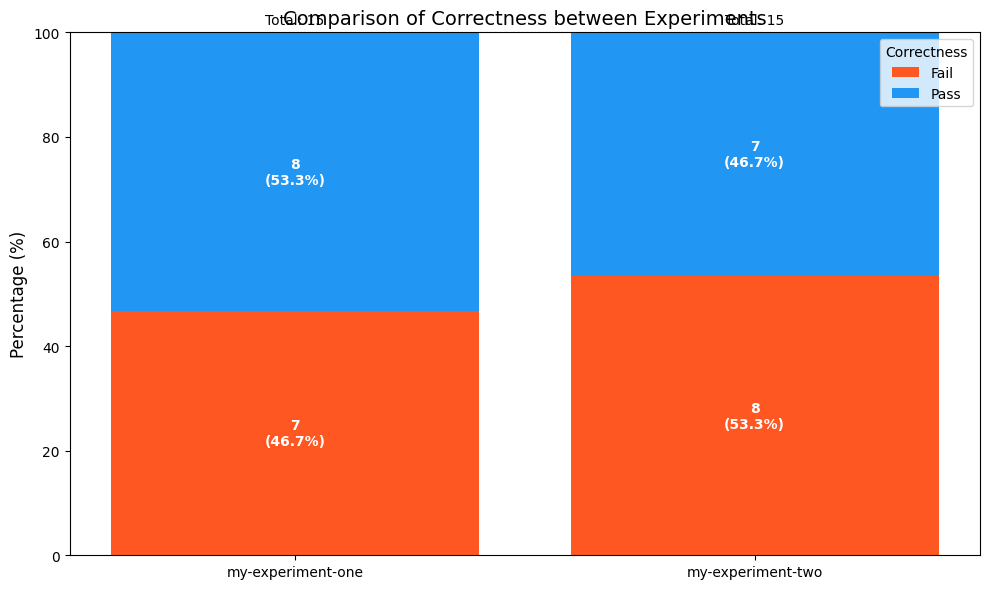

({'exp_x': ['fail',
   'fail',
   'pass',
   'pass',
   'fail',
   'pass',
   'fail',
   'fail',
   'fail',
   'pass',
   'pass',
   'fail',
   'pass',
   'pass',
   'pass'],
  'exp_y': ['pass',
   'pass',
   'pass',
   'fail',
   'fail',
   'fail',
   'fail',
   'fail',
   'fail',
   'fail',
   'pass',
   'pass',
   'pass',
   'fail',
   'pass']},
 {'pass': 8, 'fail': 7},
 {'pass': 7, 'fail': 8})

In [27]:
compare_and_plot('my-experiment-one', 'my-experiment-two', my_metric)